# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- Качество предсказания. Величина метрики RMSE должна быть менее 2500;
- Скорость предсказания;
- Время обучения.

## Подготовка данных

### Обзор данных

In [1]:
!pip install category_encoders

In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import category_encoders as ce
import lightgbm as lgb
import matplotlib.pyplot as plt

from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
df = pd.read_csv('/datasets/autos.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В нашем распоряжении имеется датасет размером примерно в 354 тысячи объектов и 16 признаков. Признаки есть строковые и целочисленные. Присутствуют пропуски и нулевые значения. 

Признаки:

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:
- `Price` — цена (евро)

### Предобработка данных


#### Дубликаты

In [9]:
# Проверим на дубликаты и удалим их.
df.duplicated().sum()

4

In [10]:
df = df.drop_duplicates().reset_index(drop=True)

df.duplicated().sum()

0

#### Проверка дат 

Проверим, что год и месяц выпуска авто не меньше, чем дата создания объявления 

##### DateCrawled


In [11]:
df['DateCrawled']

0         2016-03-24 11:52:17
1         2016-03-24 10:58:45
2         2016-03-14 12:52:21
3         2016-03-17 16:54:04
4         2016-03-31 17:25:20
                 ...         
354360    2016-03-21 09:50:58
354361    2016-03-14 17:48:27
354362    2016-03-05 19:56:21
354363    2016-03-19 18:57:12
354364    2016-03-20 19:41:08
Name: DateCrawled, Length: 354365, dtype: object

In [12]:
# Преобразуем DateCrawled в формат datetime
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCrawled']

0        2016-03-24 11:52:17
1        2016-03-24 10:58:45
2        2016-03-14 12:52:21
3        2016-03-17 16:54:04
4        2016-03-31 17:25:20
                 ...        
354360   2016-03-21 09:50:58
354361   2016-03-14 17:48:27
354362   2016-03-05 19:56:21
354363   2016-03-19 18:57:12
354364   2016-03-20 19:41:08
Name: DateCrawled, Length: 354365, dtype: datetime64[ns]

In [13]:
# Проверим самую ранюю и самую позднюю дату выгрузки
display(df['DateCrawled'].min())
df['DateCrawled'].max()

Timestamp('2016-03-05 14:06:22')

Timestamp('2016-04-07 14:36:58')

##### RegistrationYear


In [14]:
display(df['RegistrationYear'])
np.sort(df['RegistrationYear'].unique())

0         1993
1         2011
2         2004
3         2001
4         2008
          ... 
354360    2005
354361    2005
354362    2000
354363    1996
354364    2002
Name: RegistrationYear, Length: 354365, dtype: int64

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Явно есть некорректные данные. Удалим записи, значения которых меньше 1910 и больше `df['DateCrawled'].dt.year.max()`

In [15]:
df = df[(df['RegistrationYear'] >= 1910) & (df['RegistrationYear'] <= df['DateCrawled'].dt.year.max())].reset_index(drop=True)

In [16]:
df.shape[0]

339769

In [17]:
np.sort(df['RegistrationYear'].unique())

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016])

Датасет стал меньше примерно на 15000 записей.

##### RegistrationMonth


In [18]:
df['RegistrationMonth']

0         0
1         5
2         8
3         6
4         7
         ..
339764    7
339765    1
339766    3
339767    3
339768    6
Name: RegistrationMonth, Length: 339769, dtype: int64

In [19]:
np.sort(df['RegistrationMonth'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Похоже нулями заполнены объекты в случаях, если месяц регистрации был не известен.

In [20]:
df[df['RegistrationMonth'] == 0].shape[0]

33616

Довольно большое количество записей не содержит указания на месяц регистрации. Для сохранения данных будем считать, что месяцем регистрации в таком случае будет январь.

In [21]:
df['RegistrationMonth'][df['RegistrationMonth'] == 0] = 1

In [22]:
np.sort(df['RegistrationMonth'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

##### Сравнение даты регистрации и даты выгрузки

Напишем функцию, которая позволит нам отсеять записи, в которых дата регистрации позже даты выгрузки из БД.

In [23]:
# Функция для строки сравнивает дату скачивания объявления из БД с датой регистрации. 
# Возвращает False, если автомобиль зарегистрирован позже даты выгрузки из БД.
def is_date_correct(row):
    if row['RegistrationYear'] == row['DateCrawled'].year:
        if row['RegistrationMonth'] <= row['DateCrawled'].month:
            return True
        else: 
            return False
    else:
        return True

In [24]:
df['RegistrationDate_is_correct'] = df.apply(is_date_correct, axis=1)

In [25]:
df['RegistrationDate_is_correct'].value_counts()

True     334540
False      5229
Name: RegistrationDate_is_correct, dtype: int64

In [26]:
df[df['RegistrationDate_is_correct'] == False].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,RegistrationDate_is_correct
29,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07,False
33,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50,False
190,2016-04-03 20:44:13,1999,NaN,2016,manual,110,almera,150000,9,gasoline,nissan,NaN,2016-04-03 00:00:00,0,10997,2016-04-05 21:17:18,False
280,2016-03-10 20:43:12,2390,NaN,2016,NaN,83,jazz,150000,12,petrol,honda,no,2016-03-10 00:00:00,0,78713,2016-03-13 03:17:27,False
388,2016-03-08 23:53:58,4500,NaN,2016,NaN,0,fox,60000,10,NaN,volkswagen,NaN,2016-03-08 00:00:00,0,41466,2016-04-06 23:17:29,False


Чуть больше 5000 записей содержат некорректные даты регистрации. Удалим их.

In [27]:
df = df[df['RegistrationDate_is_correct'] == True].reset_index(drop=True)

In [28]:
df['RegistrationDate_is_correct'].value_counts()

True    334540
Name: RegistrationDate_is_correct, dtype: int64

#### Избыточные признаки

Откажемся от признаков, которые нам не нужны: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`, `RegistrationDate_is_correct`. От месяца регистрации отказываемся, т.к. он оказывает минимальное влияние и может только всё усложнить из-за своей повторяющейся структуры: после 12 месяца идёт 1 месяц (чтобы корректно это отобразить, необходимо выразить признак через sin/cos).



In [29]:
columns = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationDate_is_correct']

df = df.drop(columns, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334540 entries, 0 to 334539
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             334540 non-null  int64 
 1   VehicleType       316826 non-null  object
 2   RegistrationYear  334540 non-null  int64 
 3   Gearbox           317111 non-null  object
 4   Power             334540 non-null  int64 
 5   Model             317581 non-null  object
 6   Kilometer         334540 non-null  int64 
 7   FuelType          309396 non-null  object
 8   Brand             334540 non-null  object
 9   Repaired          271910 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.5+ MB


#### Уникальные объекты

Взглянем на уникальные значения в строковых признаках

In [30]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [31]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [32]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo', 'clio',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'megane', 'lupo', 'r19', 'caddy',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe',
       '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio', 'touareg',

In [33]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Обращают на себя внимание типы топлива 'lpg' и 'cng'. Это не ошибка, такие типы топлива существуют - это сжиженный газ.

> CNG is an abbreviation of “Compressed Natural Gas” whereas LPG is an abbreviation of “Liquefied Petroleum Gas”. The primary difference between CNG and LPG lies in the components that make up these fuels. While CNG is primarily made up of Methane, LPG is primarily made up of propane.

Оставляем.

In [34]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo', 'porsche',
       'rover', 'land_rover', 'lada'], dtype=object)

In [35]:
df['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

#### Пропуски

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334540 entries, 0 to 334539
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             334540 non-null  int64 
 1   VehicleType       316826 non-null  object
 2   RegistrationYear  334540 non-null  int64 
 3   Gearbox           317111 non-null  object
 4   Power             334540 non-null  int64 
 5   Model             317581 non-null  object
 6   Kilometer         334540 non-null  int64 
 7   FuelType          309396 non-null  object
 8   Brand             334540 non-null  object
 9   Repaired          271910 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.5+ MB


Довольно много пропусков в категориальных признаках и все эти признаки нам важны. Заполним пропуски значением 'no_data'.

In [37]:
df = df.fillna('no_data')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334540 entries, 0 to 334539
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             334540 non-null  int64 
 1   VehicleType       334540 non-null  object
 2   RegistrationYear  334540 non-null  int64 
 3   Gearbox           334540 non-null  object
 4   Power             334540 non-null  int64 
 5   Model             334540 non-null  object
 6   Kilometer         334540 non-null  int64 
 7   FuelType          334540 non-null  object
 8   Brand             334540 non-null  object
 9   Repaired          334540 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.5+ MB


#### Выбросы в числовых признаках

In [38]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,334540.00000,334540.000000,334540.000000,334540.000000
mean,4504.85313,2002.270948,111.372168,127979.479285
std,4558.24649,6.940503,183.722301,37950.260321
min,0.00000,1910.000000,0.000000,5000.000000
25%,1100.00000,1999.000000,69.000000,125000.000000
50%,2800.00000,2003.000000,105.000000,150000.000000
75%,6500.00000,2007.000000,143.000000,150000.000000
max,20000.00000,2016.000000,20000.000000,150000.000000


##### Price

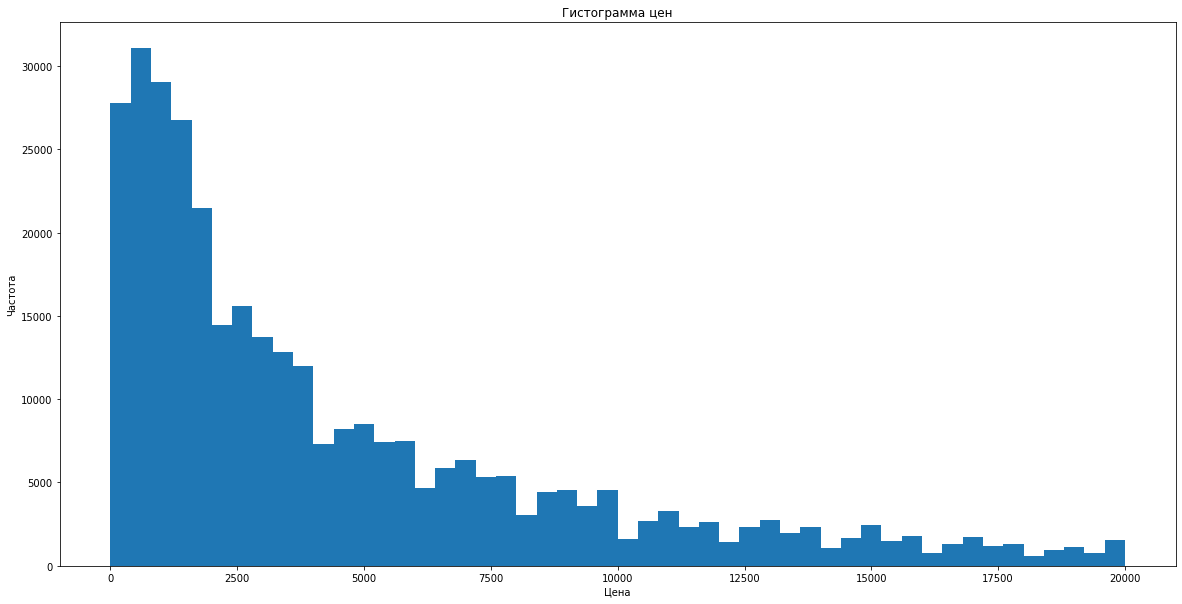

In [39]:
ax = df['Price'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма цен')

ax.set_xlabel('Цена')
ax.set_ylabel('Частота')


plt.show()

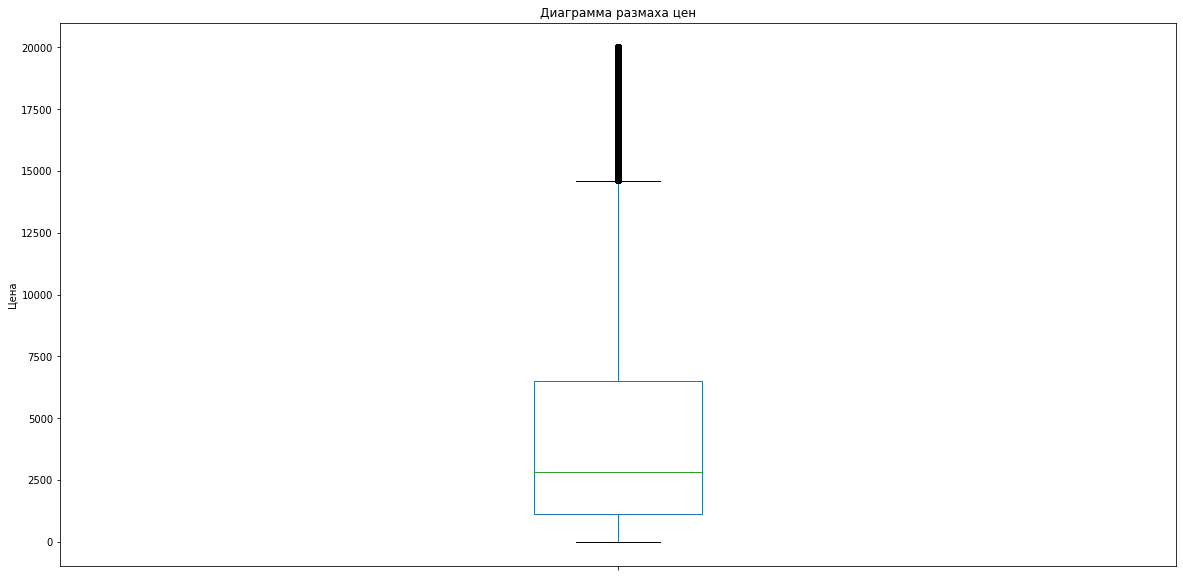

In [40]:
ax = df['Price'].plot.box(figsize=(20, 10), title='Диаграмма размаха цен')

ax.set_ylabel('Цена')
ax.set(xticklabels=[])


plt.show()

In [41]:
df['Price'].describe()

count    334540.00000
mean       4504.85313
std        4558.24649
min           0.00000
25%        1100.00000
50%        2800.00000
75%        6500.00000
max       20000.00000
Name: Price, dtype: float64

Присутствуют выбросы как снизу (нулевые значения). Так и сверху. Верхние выбросы можно объяснить продажей дорогих авто. Нижние выбросы можно объяснить тем, что кто-то хочет избавиться от машины, которая годится только на металлолом и не на ходу. Удалим значения ниже 1000 евро.

In [42]:
df = df[~(df['Price'] <= 1000)]

In [43]:
df['Price'].describe()

count    253299.000000
mean       5779.596122
std        4551.457310
min        1001.000000
25%        2200.000000
50%        4199.000000
75%        7999.000000
max       20000.000000
Name: Price, dtype: float64

##### RegistrationYear

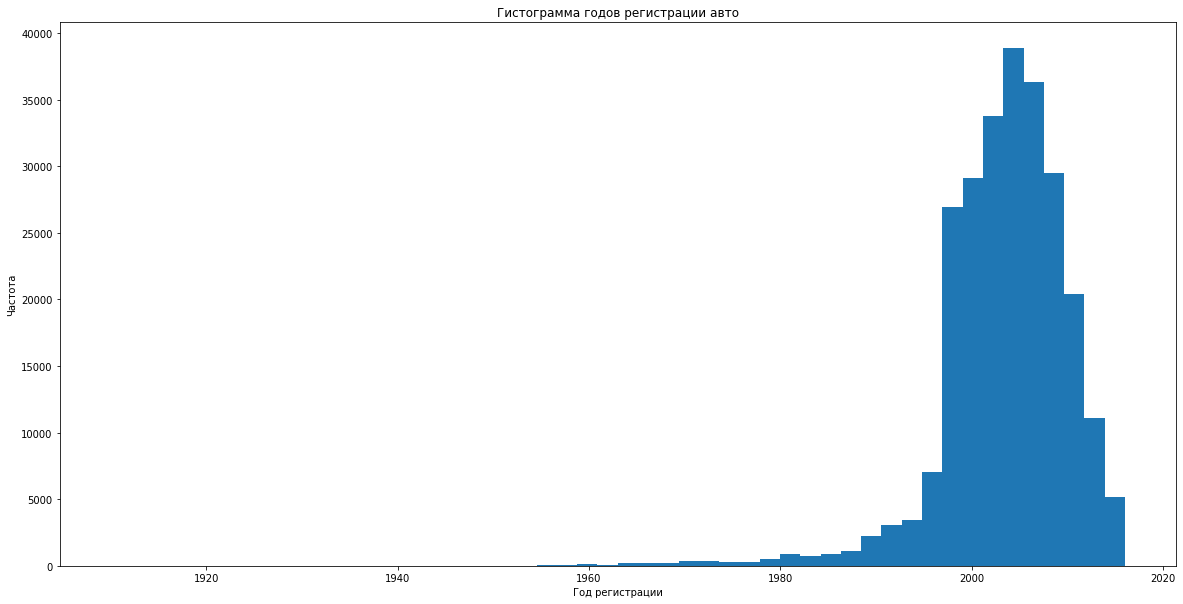

In [44]:
ax = df['RegistrationYear'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма годов регистрации авто')

ax.set_xlabel('Год регистрации')
ax.set_ylabel('Частота')


plt.show()

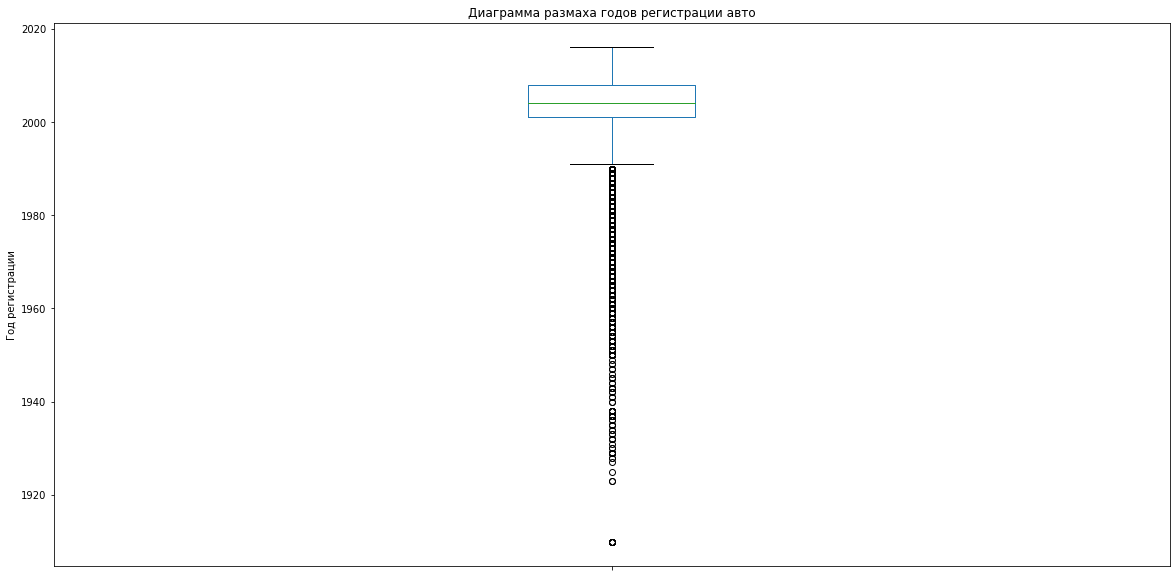

In [45]:
ax = df['RegistrationYear'].plot.box(figsize=(20, 10), title='Диаграмма размаха годов регистрации авто')

ax.set_ylabel('Год регистрации')
ax.set(xticklabels=[])


plt.show()

In [46]:
df['RegistrationYear'].describe()

count    253299.000000
mean       2003.560717
std           6.583924
min        1910.000000
25%        2001.000000
50%        2004.000000
75%        2008.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

Иногда продаются очень старые авто. Это вполне возможно и важно уметь предсказывать цену на такие раритеты. Оставим всё как есть.

##### Power

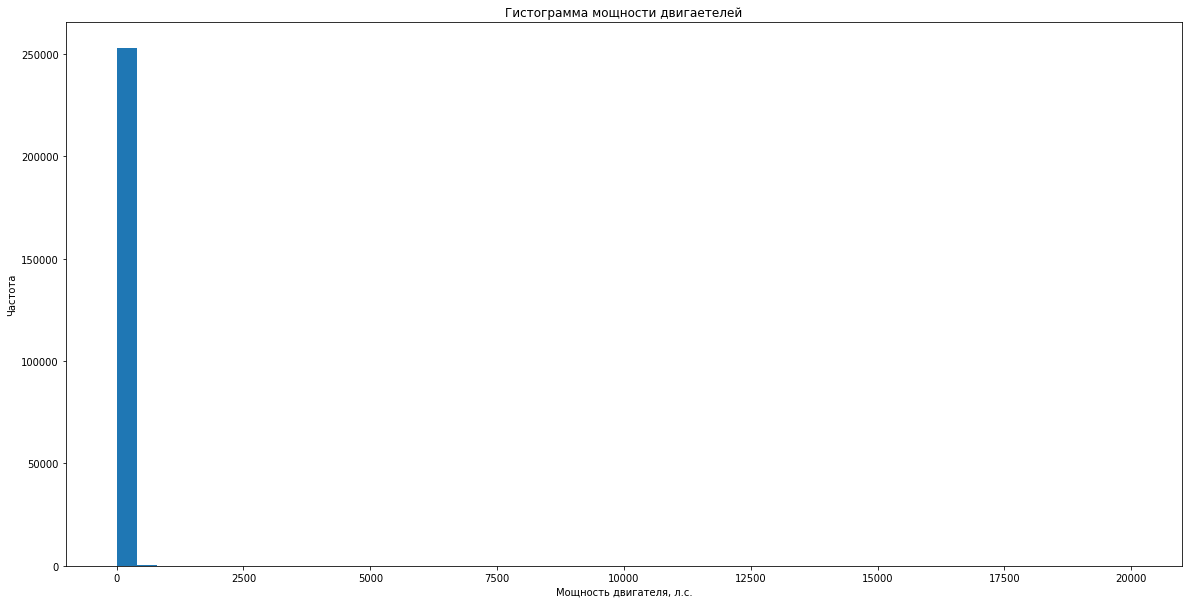

In [47]:
ax = df['Power'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма мощности двигаетелей')

ax.set_xlabel('Мощность двигателя, л.с.')
ax.set_ylabel('Частота')


plt.show()

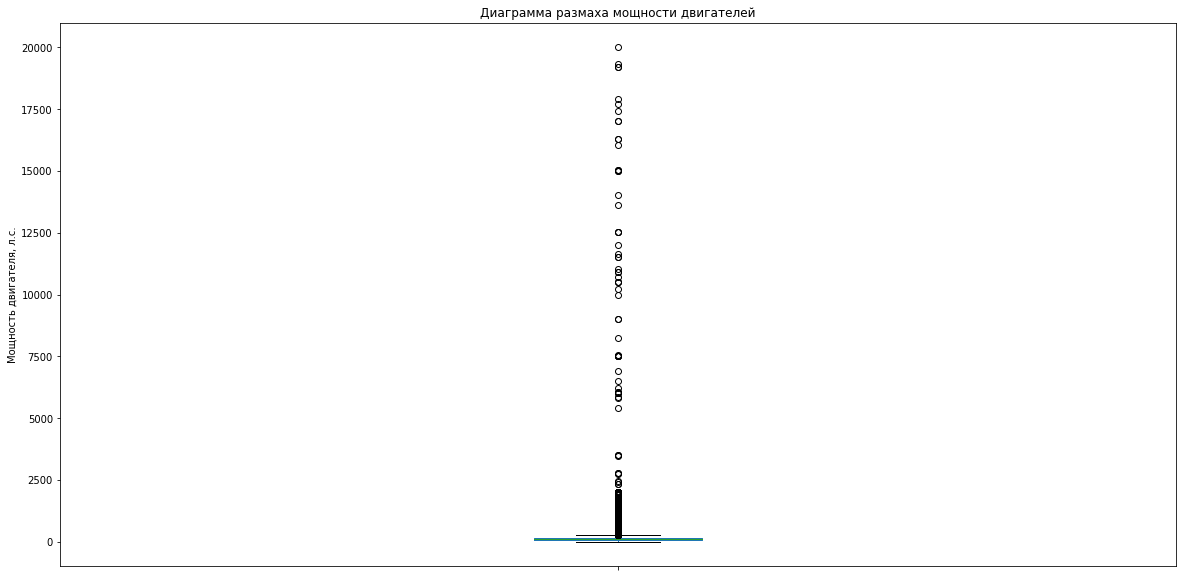

In [48]:
ax = df['Power'].plot.box(figsize=(20, 10), title='Диаграмма размаха мощности двигателей')

ax.set_ylabel('Мощность двигателя, л.с.')
ax.set(xticklabels=[])


plt.show()

In [49]:
df['Power'].describe()

count    253299.000000
mean        123.277238
std         191.215335
min           0.000000
25%          80.000000
50%         116.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

Большие выбросы сверху. С высокой вероятностью - ошибка. Даже самые огромные экскаваторы LIEBHERR имеют только 4000 л.с. Некоторые штучные гоночные авто могут иметь 5000 л.с. ДВС для морских кораблей могут иметь подобную мощность, но мы их не продаём, поэтому уберём эти аномалии. 

Основываясь на [этой статье](https://www.cnet.com/roadshow/pictures/least-powerful-lowest-horsepower-cars-you-can-buy-pictures/5/), уберём автомобили с мощностью ДВС менее 100 л.с.

In [50]:
top_cutoff = df['Power'].quantile(0.99)

display(top_cutoff)

306.0

99-ый перцентиль показывает адекватное значение. Оставим его в качестве верхнего предела.

In [51]:
df = df[(df['Power'] >= 100) & (df['Power'] <= top_cutoff)].reset_index(drop=True)

In [52]:
df['Power'].describe()

count    165743.000000
mean        148.689441
std          41.905578
min         100.000000
25%         116.000000
50%         140.000000
75%         170.000000
max         306.000000
Name: Power, dtype: float64

##### Kilometer

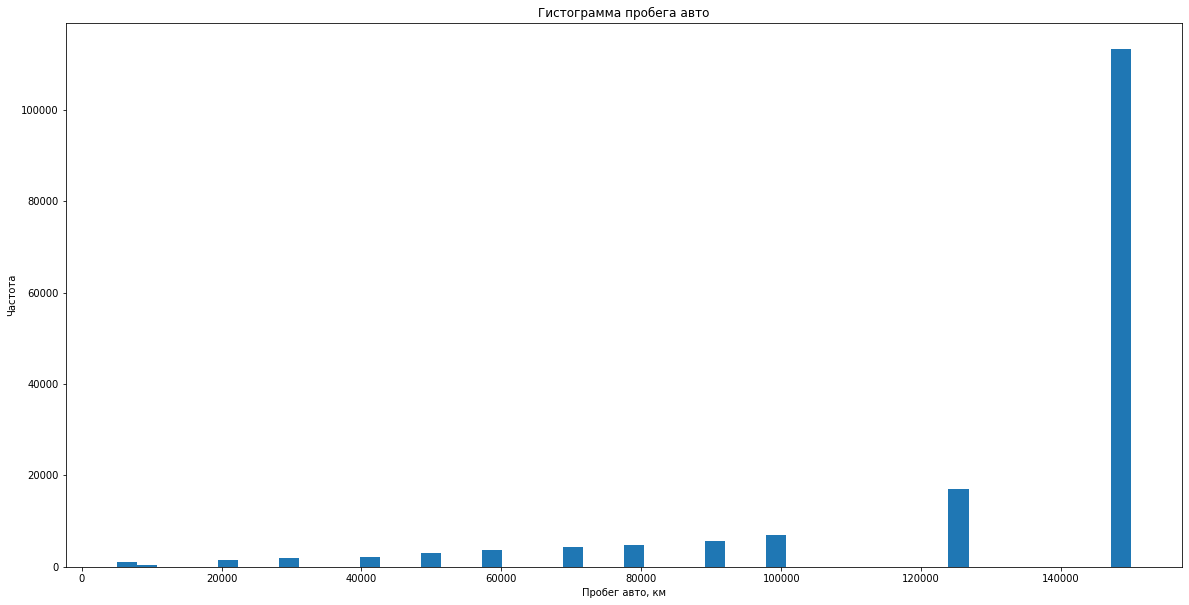

In [53]:
ax = df['Kilometer'].plot.hist(bins=50, figsize=(20, 10), title='Гистограмма пробега авто')

ax.set_xlabel('Пробег авто, км')
ax.set_ylabel('Частота')


plt.show()

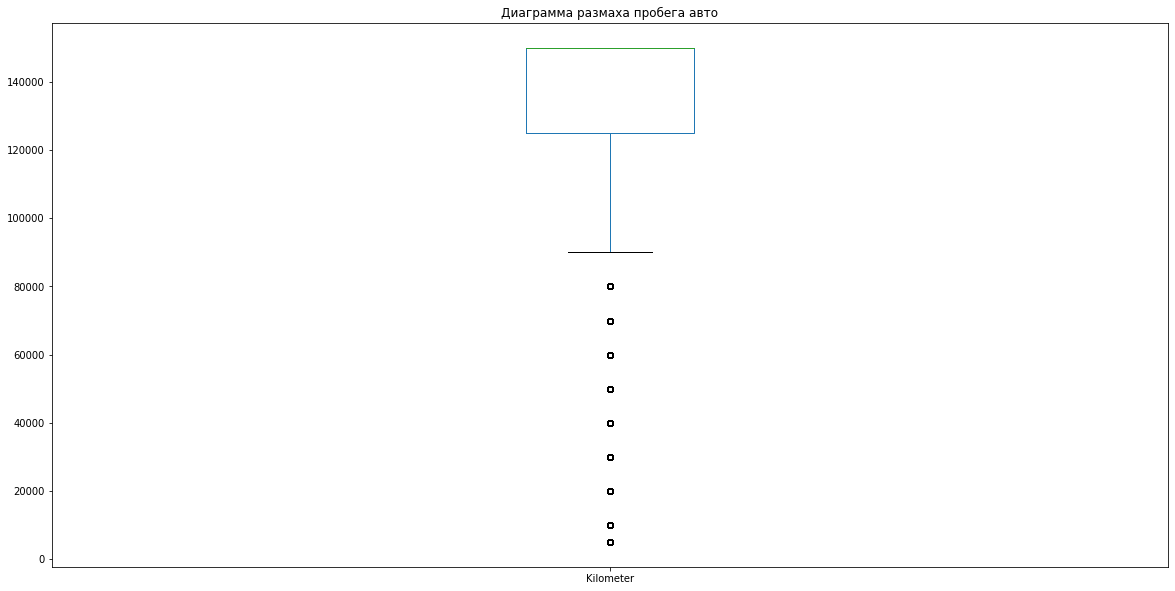

In [54]:
df['Kilometer'].plot.box(figsize=(20, 10), title='Диаграмма размаха пробега авто')

ax.set_ylabel('Пробег авто, км')
ax.set(xticklabels=[])


plt.show()

In [55]:
df['Kilometer'].describe()

count    165743.000000
mean     130107.003011
std       34983.548652
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Присутствуют выбросы снизу. Вполне может быть правдоподобно - машина стояла в гараже и не ездила. Оставим всё как есть. 

#### Повторная проверка на дубликаты

In [56]:
# Проверим ещё раз на дубликаты и удалим их.
df.duplicated().sum()

21105

In [57]:
df = df.drop_duplicates().reset_index(drop=True)

df.duplicated().sum()

0

#### Выводы

In [58]:
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144638 entries, 0 to 144637
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             144638 non-null  int64 
 1   VehicleType       144638 non-null  object
 2   RegistrationYear  144638 non-null  int64 
 3   Gearbox           144638 non-null  object
 4   Power             144638 non-null  int64 
 5   Model             144638 non-null  object
 6   Kilometer         144638 non-null  int64 
 7   FuelType          144638 non-null  object
 8   Brand             144638 non-null  object
 9   Repaired          144638 non-null  object
dtypes: int64(4), object(6)
memory usage: 11.0+ MB


None

,Price,RegistrationYear,Power,Kilometer
count,144638.000000,144638.000000,144638.000000,144638.000000
mean,6807.832354,2004.003326,149.052248,129434.657559
std,4863.461551,5.747974,42.125440,35409.804901
min,1001.000000,1937.000000,100.000000,5000.000000
25%,2800.000000,2001.000000,116.000000,125000.000000
50%,5499.000000,2005.000000,140.000000,150000.000000
75%,9800.000000,2008.000000,170.000000,150000.000000
max,20000.000000,2016.000000,306.000000,150000.000000


В результате предобработки данных были обнаружены и обработаны аномалии в датасете. Размер датасета уменьшился с 350 тыс. объектов до 144 тыс. объектов. Были обработаны дубликаты, выбросы, некорректные записи

## Обучение моделей

### Разделение, кодирование и масштабирование данных 

#### Разделение выборок

In [59]:
X = df.drop('Price', axis=1)
y = df['Price']

In [60]:
X.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,coupe,2011,manual,190,no_data,125000,gasoline,audi,yes
1,suv,2004,auto,163,grand,125000,gasoline,jeep,no_data
2,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
3,bus,2014,manual,125,c_max,30000,petrol,ford,no_data
4,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


In [61]:
y.head()

0    18300
1     9800
2     2200
3    14500
4     2000
Name: Price, dtype: int64

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=987654321)

#### Кодирование и масштабирование признаков

Ещё раз посмотрим на категориальные признаки

In [63]:
df['VehicleType'].unique()

array(['coupe', 'suv', 'convertible', 'bus', 'sedan', 'wagon', 'other',
       'no_data', 'small'], dtype=object)

In [64]:
df['Gearbox'].unique()

array(['manual', 'auto', 'no_data'], dtype=object)

In [65]:
df['Model'].unique()

array(['no_data', 'grand', '2_reihe', 'c_max', '3_reihe', 'passat',
       'navara', 'a_klasse', 'scirocco', '5er', 'e_klasse', '3er',
       'other', '1er', 'b_klasse', 'a8', 'jetta', 'c_klasse', 'golf',
       'sprinter', 'forester', 'xc_reihe', 'scenic', 'focus', 'a4', 'tt',
       'astra', 'a6', 'transporter', 'slk', '7er', '80', 'civic', '147',
       'z_reihe', 'sorento', 'mustang', 'eos', 'vito', 'fabia', 'touran',
       'insignia', 'megane', 'a3', 'impreza', 'a1', 'clio', 'tiguan',
       '6_reihe', 'i_reihe', '5_reihe', 'yeti', 'octavia', 'zafira',
       'rx_reihe', '6er', 'vectra', 'beetle', 'touareg', 'ibiza',
       'spider', 's_max', 'galaxy', 'c3', 'viano', 'mondeo', 'sharan',
       'avensis', 'sl', 'santa', 'leon', 'cooper', '4_reihe', 'a5',
       'sportage', 'laguna', 'ptcruiser', 'clk', 'primera', 's_klasse',
       'exeo', 'polo', '159', 'transit', 'juke', 'x_reihe', 'espace',
       'c4', 'accord', 'corolla', 'phaeton', 'verso', 'rav', 'caddy',
       'qashqai', 

In [66]:
df['FuelType'].unique()

array(['gasoline', 'petrol', 'no_data', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [67]:
df['Brand'].unique()

array(['audi', 'jeep', 'peugeot', 'ford', 'mazda', 'volkswagen', 'nissan',
       'mercedes_benz', 'bmw', 'honda', 'subaru', 'volvo', 'renault',
       'opel', 'alfa_romeo', 'kia', 'skoda', 'lancia', 'mitsubishi',
       'toyota', 'hyundai', 'seat', 'citroen', 'mini', 'chrysler',
       'sonstige_autos', 'jaguar', 'suzuki', 'rover', 'porsche', 'fiat',
       'saab', 'chevrolet', 'dacia', 'land_rover', 'lada', 'daewoo',
       'smart', 'daihatsu'], dtype=object)

In [68]:
df['Repaired'].unique()

array(['yes', 'no_data', 'no'], dtype=object)

In [69]:
df['RegistrationYear'].unique()

array([2011, 2004, 2014, 2005, 2007, 2009, 2002, 1995, 2006, 1998, 2012,
       2008, 2000, 1992, 1997, 1984, 2003, 1999, 1991, 1996, 2001, 2010,
       2015, 1994, 1989, 2013, 1983, 1981, 1969, 2016, 1990, 1985, 1988,
       1980, 1993, 1986, 1974, 1987, 1982, 1978, 1976, 1972, 1968, 1966,
       1961, 1977, 1979, 1973, 1965, 1975, 1971, 1958, 1962, 1956, 1970,
       1959, 1950, 1951, 1963, 1967, 1955, 1964, 1960, 1952, 1957, 1948,
       1954, 1937, 1947])

In [70]:
df['Kilometer'].unique()

array([125000, 150000,  30000,  70000, 100000,  20000,  50000,   5000,
        60000,  10000,  90000,  80000,  40000])

Признаки VehicleType, Model, FuelType, Brand имеют довольно много значений. Особенно Model. RegistrationYear и Kilometer так же являются категориальными признаками, несмотря на то, что содержат числовые значения.

Закодируем категориальные признаки с помощью бинарного кодирования (это смесь Hash Encoding и One-Hot Encoding). Бинарное кодирование хорошо себя показывает, когда категориальные признаки имеют большое множество значений и данное кодирование позволяет не раздувать пространство признаков слишком сильно.

In [71]:
cat_features = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'RegistrationYear', 'Kilometer']
num_features = ['Power']

In [72]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [73]:
# Кодирование и масштабирование прризнаков
encoder = ce.BinaryEncoder(cols=cat_features, return_df=True)

encoder.fit(X_train_copy)

X_train_copy = encoder.transform(X_train_copy)
X_test_copy = encoder.transform(X_test_copy)

scaler = StandardScaler()
scaler.fit(X_train_copy[num_features])

X_train_copy[num_features] = scaler.transform(X_train_copy[num_features])
X_test_copy[num_features] = scaler.transform(X_test_copy[num_features])

In [74]:
X_train_copy.head()

,VehicleType_0,VehicleType_1,VehicleType_2,VehicleType_3,RegistrationYear_0,RegistrationYear_1,RegistrationYear_2,RegistrationYear_3,RegistrationYear_4,RegistrationYear_5,...,FuelType_2,FuelType_3,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Repaired_0,Repaired_1
24656,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
12385,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
74131,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,1
130356,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
84668,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,1


In [75]:
X_test_copy.head()

,VehicleType_0,VehicleType_1,VehicleType_2,VehicleType_3,RegistrationYear_0,RegistrationYear_1,RegistrationYear_2,RegistrationYear_3,RegistrationYear_4,RegistrationYear_5,...,FuelType_2,FuelType_3,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Repaired_0,Repaired_1
72829,0,0,1,0,0,0,0,1,1,1,...,0,1,0,0,0,0,1,0,0,1
88436,1,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,1,1,0,1
116771,0,1,1,1,0,0,0,0,1,0,...,0,1,0,0,1,1,0,1,1,1
20726,0,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,1
10928,0,0,1,0,0,0,0,0,1,1,...,0,1,0,0,0,1,1,1,1,0


### Линейная регрессия 

In [76]:
model_lr = LinearRegression()

scores = cross_val_score(model_lr, 
                         X_train_copy, 
                         y_train, 
                         cv=5, 
                         scoring='neg_root_mean_squared_error'
                        )

lr_score_mean = scores.mean()

display(scores)
display(f'Среднее значение метрики RMSE для линейной регрессии с использованием кросс-валидации равно: {abs(lr_score_mean)}')

array([-3119.75303338, -3122.97386576, -3172.66260242, -3116.35339527,
       -3106.48031519])

'Среднее значение метрики RMSE для линейной регрессии с использованием кросс-валидации равно: 3127.644642405879'

In [77]:
start = time()
model_lr.fit(X_train_copy, y_train)
end = time()

model_lr_train_time = end-start


start = time()
model_lr.predict(X_train_copy)
end = time()

model_lr_predict_time = end-start

display(f'Время обучения для линейной регрессии равно: {model_lr_train_time} сек.')
f'Время предсказания для линейной регрессии равно: {model_lr_predict_time} сек.'

'Время обучения для линейной регрессии равно: 0.5996513366699219 сек.'

'Время предсказания для линейной регрессии равно: 0.08896660804748535 сек.'

###  LightGBM

In [78]:
params = {
    'max_depth': [4, 6],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9],
    'min_child_samples': [1, 5, 10],
    'num_leaves': [40]
}


estimator_lgb = lgb.LGBMRegressor(objective='regression', 
                              random_state=42)

model_lgb = GridSearchCV(estimator=estimator_lgb, 
                         param_grid=params, 
                         cv=5, 
                         n_jobs=-1,
                         scoring='neg_root_mean_squared_error'
                        )

model_lgb.fit(X_train_copy, y_train)

best_model_lgb = model_lgb.best_estimator_
best_params_lgb = model_lgb.best_params_
best_score_lgb = model_lgb.best_score_

display(f'Лучшие параметры: {best_params_lgb}')
display(f'RMSE лучшей модели: {abs(best_score_lgb)}')

"Лучшие параметры: {'colsample_bytree': 0.8, 'max_depth': 6, 'min_child_samples': 5, 'num_leaves': 40, 'subsample': 0.7}"

'RMSE лучшей модели: 2034.1266284678193'

In [79]:
start = time()
best_model_lgb.fit(X_train_copy, y_train)
end = time()

model_lgb_train_time = end-start


start = time()
best_model_lgb.predict(X_train_copy)
end = time()

model_lgb_predict_time = end-start

display(f'Время обучения для LightGBM равно: {model_lgb_train_time} сек.')
f'Время предсказания для LightGBM равно: {model_lgb_predict_time} сек.'

'Время обучения для LightGBM равно: 4.306342840194702 сек.'

'Время предсказания для LightGBM равно: 0.8864963054656982 сек.'

## Анализ моделей

Сравним метрики обученных моделей и скорость их обучения.

In [80]:
display(f'Метрика RMSE')
display(f'Линейная регрессия: {abs(lr_score_mean.round(2))} eur')
display(f'LightGBM: {abs(best_score_lgb.round(2))} eur')
display(f'------')
display(f'Время обучения')
display(f'Линейная регрессия: {round(model_lr_train_time, 2)} сек.')
display(f'LightGBM: {round(model_lgb_train_time, 2)} сек.')
display(f'------')
display(f'Время предсказания')
display(f'Линейная регрессия: {round(model_lr_predict_time, 2)} сек.')
display(f'LightGBM: {round(model_lgb_predict_time, 2)} сек.')

'RMSE составляет:'

'Линейная регрессия: 3127.64 eur'

'LightGBM: 2034.13 eur'

'------'

'Время обучения'

'Линейная регрессия: 0.6 сек.'

'LightGBM: 4.31 сек.'

'------'

'Время предсказания'

'Линейная регрессия: 0.09 сек.'

'LightGBM: 0.89 сек.'

Модель LightGBM показала лучшее значение метрики RMSE при увеличенных затратах по времени на обучение и предсказание. Проверим её против константной модели.

In [81]:
model_dr = DummyRegressor()

model_dr.fit(X_train_copy, y_train)
predictions_dr = model_dr.predict(X_train_copy)
score_dr = mean_squared_error(y_train, predictions_dr, squared=False)

f'RMSE константной модели равно {abs(score_dr)}'

'RMSE константной модели равно 4868.406451413606'

Наша модель LightGBM показывает лучшие результаты, чем константая модель. Проверим теперь лучшую модель на тестовой выборке

In [82]:
predictions_final = best_model_lgb.predict(X_test_copy)

score_final = mean_squared_error(y_test, predictions_final, squared=False)

f'RMSE LightGBM модели на тестовой выборке равно {abs(score_final)}'

'RMSE LightGBM модели на тестовой выборке равно 2022.4118735443558'

На тестовой выборке лучшая модель показывает ожидаемую величину метрики RMSE. Модель подходит для внедрения в эксплуатацию.

## Итоговый вывод

Наша задача состояла в следующем:

> Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.<br><br>
> Заказчику важны:
> - Качество предсказания. Величина метрики RMSE должна быть менее 2500;
> - Скорость предсказания;
> - Время обучения.

Проделаны были следующие этапы:
1. Выполнена предобработка данных. Аномалии, выбросы, некорректные значения были обработаны.
2. Обучены с применением кросс-валидации модели линейной регрессии и LightGBM. Для LightGBM были найдены оптимальные гиперпараметры с помощью `GridSearchCV`.
3. Проведено сравнение обученных моделей по метрике RMSE и скорости обучения и предсказания. Модель LightGBM обучается и предсказывает медленнее, но показывает лучший результат по метрике RMSE.
    1. Проведено сравнение лучшей модели с константной моделью.
    2. Проведена проверка лучшей модели на тестовой выборке.
    
В результате получена модель, соответствующая критериям заказчика и готовая для внедрения в эксплуатацию. 
